In [1]:
#@title **Install External libraries** { display-mode: 'form' }
!pip install stable-baselines3 gymnasium JaxFin scienceplots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [2]:
!pip install sbx-rl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 1.3 MB/s eta 0:00:00


In [3]:
# @title Imports
# @markdown Do you want to save the model?
from abc import ABCMeta, abstractmethod
from itertools import product

import numpy as np
from numpy.random import choice

from gymnasium import Env, spaces
from gymnasium.spaces import Box, Discrete
from gymnasium.wrappers import NormalizeObservation
from google.colab import drive

from jax import vmap

from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.models.gbm import UnivGeometricBrownianMotion

import matplotlib.pyplot as plt

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from sbx import TD3
import scienceplots

import pprint

import torch as th

SEED: int = 0
SAVE: bool = True # @param ["False", "True"] {type:"raw"}

plt.style.use(['science','no-latex'])
np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


## BS environment


In [4]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))


def flatten(fn):
    def wrapper(*args, **kwargs):
        return fn(*args, **kwargs).flatten()

    return wrapper


class HedgingEnvBase(Env):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    __metaclass__ = ABCMeta

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        self.s0 = s0
        self.strike = strike
        self.expiry = expiry
        self.r = r
        self.mu = mu
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = expiry / n_steps
        self._current_step = 0

        self.render_mode = "human"

        self._stock_path = np.array([])
        self._call_prices = np.array([])
        self._deltas = np.array([])

        self._current_pnl = 0.0
        self._hedging_portfolio_value = 0.0
        self._current_hedging_delta = 0.0
        self._previous_hedging_delta = 0.0
        self._back_account_value = 0.0
        self._ddelta = 0.0

        self._epsilon = 1
        self._lambda = 0.1
        self._tick_size = 0.05

    def reset(self, seed=None):
        super().reset(seed=seed)

        self._current_step = 0
        self._current_pnl = 0.0
        self._ddelta = 0.0
        self._stock_path = self._generate_stock_path(seed=seed)
        self._call_prices = self._get_call_prices()
        self._deltas = self._get_deltas()
        self._hedging_portfolio_value = self._call_prices[0]
        self._current_hedging_delta = -self._deltas[0]
        self._back_account_value = -(
            self._hedging_portfolio_value + self.current_hedging_delta * self.s0
        )

        observations = self._get_observations()
        infos = self._get_infos()

        return observations, infos

    def step(self, action: float):
        self._current_step += 1

        done = self._current_step == (self.n_steps - 1)
        reward = self._calculate_reward()

        self._hedging_portfolio_value = self._calculate_hedging_portfolio_value(action)

        observations = self._get_observations()
        infos = self._get_infos()
        self._update_delta(action)

        return observations, reward, done, False, infos

    def render(self, mode="human"):
        pass

    def _update_delta(self, new_delta: float):
        self._ddelta = new_delta - self.current_hedging_delta
        self._previous_hedging_delta = self.current_hedging_delta
        self.current_hedging_delta = new_delta

    def _calculate_reward(self) -> float:
        pnl = self._calculate_pnl()
        self._current_pnl = pnl
        return pnl - self._lambda / 2 * pnl**2

    def _calculate_pnl(self) -> float:
        dv = (
            self._call_prices[self._current_step]
            - self._call_prices[self._current_step - 1]
        )
        ds = (
            self._stock_path[self._current_step]
            - self._stock_path[self._current_step - 1]
        )[0]
        ddelta = self._ddelta

        return (
            dv + self.current_hedging_delta * ds - self._get_transaction_costs(ddelta)
        )

    def _get_transaction_costs(self, ddelta: float):
        return self._epsilon * self._tick_size * (np.abs(ddelta) + 0.01 * ddelta**2)

    def _get_observations(self):
        log_price_strike = self._get_log_ratio()
        time_to_expiration = self.expiry
        bs_delta = self._deltas[self._current_step]
        call_price = self._call_prices[self._current_step]
        return np.asarray(
            [
                log_price_strike,
                self._get_current_stock_vol(self._current_step),
                time_to_expiration,
                bs_delta,
                call_price / self._call_prices[0],
                self.current_hedging_delta,
            ],
            dtype=np.float32,
        )

    def _get_infos(self):
        return {
            "price": self._call_prices[self._current_step],
            "time_to_expiration": self.expiry - self._current_step * self.dt,
            "bs_delta": self._deltas[self._current_step],
            "stock_price": self._get_current_stock_price(),
            "current_delta": self.current_hedging_delta,
            "log(S/K)": self._get_log_ratio(),
            "hedge_portfolio_value": self._hedging_portfolio_value,
            "bank_account": self._back_account_value,
            "current_pnl": self._current_pnl,
        }

    @property
    def current_hedging_delta(self):
        return self._current_hedging_delta

    @current_hedging_delta.setter
    def current_hedging_delta(self, new_hedge: float):
        self._current_hedging_delta = new_hedge

    def _get_log_ratio(self):
        if self._current_step == -1:
            return np.log(self.s0 / self.strike)
        return np.log(self._stock_path[self._current_step, 0] / self.strike)

    @abstractmethod
    def _get_current_stock_vol(self, step: int) -> float:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _generate_stock_path(self, seed=None) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _get_call_prices(self) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _get_deltas(self) -> np.ndarray:
        raise NotImplementedError("Subclasses must implement this method")

    def _calculate_hedging_portfolio_value(self, new_delta: float):
        new_hedging_port_value = (
            self._back_account_value
            + self._current_hedging_delta * self._get_current_stock_price()
        )
        transcation_costs = self._get_transaction_costs(self._ddelta)
        self._back_account_value = (
            new_hedging_port_value
            - new_delta * self._get_current_stock_price()
            - transcation_costs
        )

        return -new_hedging_port_value

    def _get_current_stock_price(self):
        return self._stock_path[self._current_step, 0]


class BlackScholesEnvBase(HedgingEnvBase):
    metadata = {"render.modes": ["human"]}
    action_space: spaces.Space
    observation_space: spaces.Space

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )

    def _generate_stock_path(self, seed=None) -> np.ndarray:
        if seed:
            seed = 0

        gbm = UnivGeometricBrownianMotion(self.s0, self.mu, self.sigma)

        return np.asarray(gbm.sample_paths(self.expiry, self.n_steps, 1))

    def _get_current_stock_vol(self, step: int) -> float:
        return self.sigma

    @flatten
    def _get_call_prices(self) -> np.ndarray:
        return np.asarray(
            [
                european_price(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self.sigma,
                    self.r,
                )
                for i in range(self.n_steps)
            ]
        )

    @flatten
    def _get_deltas(self) -> np.ndarray:
        return np.asarray(
            [
                v_delta_european(
                    self._stock_path[i],
                    self.strike,
                    self.expiry - i * self.dt,
                    self.sigma,
                    self.r,
                )
                for i in range(self.n_steps)
            ]
        )


class BlackScholesEnvCont(BlackScholesEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )
        self.action_space = Box(low=-1.0, high=0.0, shape=(1,))
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: np.ndarray):
        new_hedge = action[0]
        return super().step(new_hedge)


class BlackScholesEnvDis(BlackScholesEnvBase):

    def __init__(
        self,
        s0: float,
        strike: float,
        expiry: float,
        r: float,
        mu: float,
        sigma: float,
        n_steps: int,
    ):
        super().__init__(
            s0=s0,
            strike=strike,
            expiry=expiry,
            r=r,
            mu=mu,
            sigma=sigma,
            n_steps=n_steps,
        )
        self.action_space = Discrete(100)
        self.observation_space = Box(
            low=np.array([-np.inf, 0.0, 0.0, 0.0, 0.0, -1.0], dtype=np.float32),
            high=np.array([np.inf, 2.0, np.inf, 1.0, np.inf, 1.0], dtype=np.float32),
            shape=(6,),
        )

    def step(self, action: float):
        return super().step(-(action / 100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
check_env(BlackScholesEnvCont(100, 100, 1.0, 0.0, 0.0, 0.2, 252))

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


## TD3

In [6]:
expires = [0.25, 0.5, 1.0, 2.0]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]
n_steps = [63, 126, 252, 504]

cartesian_product = list(product(expires, sigmas, n_steps))

In [7]:
indexes = choice(np.asarray(range(len(cartesian_product))), 79, replace=False)
random_sample = np.asarray(cartesian_product)[indexes]

In [8]:
r = 0.0
mu = 0.0

init_s0 = 100
s0 = init_s0
init_K = 100
init_T = 1.0
init_vol = 0.2
init_n_steps = 252

n_episodes = 100

In [9]:
def make_env(s0, strike, expiry, r, mu, vol, n_steps):
    def _create_env():
        return BlackScholesEnvCont(s0, strike, expiry, r, mu, vol, n_steps)
    return _create_env

def make_vec_env(s0: float, strike: float, expiry:float, r: float, mu: float, vol: float, n_steps: int) -> Env:
    vec_env = DummyVecEnv([make_env(s0, strike, expiry, r, mu, vol, n_steps) for _ in range(5)])
    return VecMonitor(vec_env, info_keywords=("current_pnl",), filename='./training.log')

In [10]:
initial_env = make_vec_env(init_s0, init_K, init_T, r, mu, init_vol, init_n_steps)

In [11]:
learning_rate = 0.0005
batch_size = 128
gamma = 0.9999
train_freq = 100
policy_kwargs = dict(
    net_arch=dict(pi=[64, 64], qf=[64, 64])
)

model = TD3("MlpPolicy",
             initial_env,
             learning_rate=learning_rate,
             batch_size=batch_size,
             gamma=gamma,
             train_freq=train_freq,
             policy_kwargs=policy_kwargs,
             verbose=0)

## Training

In [12]:
model.learn(total_timesteps=252*n_episodes, log_interval=10, progress_bar=True)

Output()

In [13]:
training_rewards = [evaluate_policy(model, initial_env, n_eval_episodes=10)[0]]

In [14]:
# train loop
for T, vol, steps in random_sample:
    n_steps = int(steps)
    K = np.random.randint(low=int(s0 * 0.8), high=int(s0 * 1.2))
    print(f's0: {s0}, K: {K}, T: {T}, vol: {vol}, steps: {steps}')
    env = make_vec_env(s0, K, T, r, mu, vol, n_steps)
    model.set_env(env)
    model.learn(total_timesteps=n_steps*n_episodes, log_interval=10, progress_bar=True)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    training_rewards.append(mean_reward)
    print(f'Training reward: {mean_reward}')

s0: 100, K: 98, T: 0.25, vol: 0.4, steps: 126.0


Output()

Training reward: -0.4353041648864746
s0: 100, K: 94, T: 0.25, vol: 0.3, steps: 504.0


Output()

Training reward: 0.4239885210990906
s0: 100, K: 118, T: 2.0, vol: 0.2, steps: 126.0


Output()

Training reward: -0.32584428787231445
s0: 100, K: 105, T: 2.0, vol: 0.2, steps: 252.0


Output()

Training reward: -3.2380032539367676
s0: 100, K: 117, T: 1.0, vol: 0.2, steps: 504.0


Output()

Training reward: 0.015100693330168724
s0: 100, K: 87, T: 1.0, vol: 0.4, steps: 252.0


Output()

Training reward: -5.089282035827637
s0: 100, K: 98, T: 1.0, vol: 0.4, steps: 504.0


Output()

Training reward: -2.9664440155029297
s0: 100, K: 109, T: 0.25, vol: 0.1, steps: 252.0


Output()

Training reward: -1.543168306350708
s0: 100, K: 81, T: 1.0, vol: 0.2, steps: 252.0


Output()

Training reward: -11.079752922058105
s0: 100, K: 89, T: 0.25, vol: 0.5, steps: 504.0


Output()

Training reward: -0.49140945076942444
s0: 100, K: 98, T: 0.5, vol: 0.5, steps: 504.0


Output()

Training reward: -10.126446723937988
s0: 100, K: 82, T: 1.0, vol: 0.1, steps: 126.0


Output()

Training reward: -4.372169494628906
s0: 100, K: 109, T: 1.0, vol: 0.3, steps: 252.0


Output()

Training reward: -0.9807014465332031
s0: 100, K: 107, T: 0.25, vol: 0.1, steps: 504.0


Output()

Training reward: -0.9935562014579773
s0: 100, K: 119, T: 1.0, vol: 0.3, steps: 63.0


Output()

Training reward: 0.3522741496562958
s0: 100, K: 88, T: 0.25, vol: 0.4, steps: 63.0


Output()

Training reward: -1.5069586038589478
s0: 100, K: 87, T: 0.25, vol: 0.5, steps: 252.0


Output()

Training reward: -2.4247689247131348
s0: 100, K: 106, T: 0.5, vol: 0.5, steps: 126.0


Output()

Training reward: -1.186085820198059
s0: 100, K: 92, T: 2.0, vol: 0.3, steps: 252.0


Output()

Training reward: -6.046141624450684
s0: 100, K: 103, T: 0.25, vol: 0.3, steps: 63.0


Output()

Training reward: -0.06614311039447784
s0: 100, K: 106, T: 0.5, vol: 0.1, steps: 126.0


Output()

Training reward: -0.9232162237167358
s0: 100, K: 117, T: 0.5, vol: 0.4, steps: 126.0


Output()

Training reward: -1.7660022974014282
s0: 100, K: 104, T: 0.5, vol: 0.3, steps: 504.0


Output()

Training reward: 0.38860589265823364
s0: 100, K: 114, T: 0.5, vol: 0.5, steps: 252.0


Output()

Training reward: -0.019781088456511497
s0: 100, K: 83, T: 1.0, vol: 0.5, steps: 126.0


Output()

Training reward: -29.001018524169922
s0: 100, K: 113, T: 0.5, vol: 0.2, steps: 63.0


Output()

Training reward: -1.1595128774642944
s0: 100, K: 87, T: 0.5, vol: 0.4, steps: 504.0


Output()

Training reward: -0.4177810549736023
s0: 100, K: 98, T: 2.0, vol: 0.2, steps: 504.0


Output()

Training reward: -3.9608421325683594
s0: 100, K: 106, T: 1.0, vol: 0.3, steps: 126.0


Output()

Training reward: -1.803008794784546
s0: 100, K: 92, T: 0.5, vol: 0.2, steps: 252.0


Output()

Training reward: -0.9515466690063477
s0: 100, K: 82, T: 0.5, vol: 0.2, steps: 504.0


Output()

Training reward: 0.16553975641727448
s0: 100, K: 111, T: 0.25, vol: 0.1, steps: 63.0


Output()

Training reward: -0.6929601430892944
s0: 100, K: 87, T: 2.0, vol: 0.5, steps: 504.0


Output()

Training reward: -27.846908569335938
s0: 100, K: 113, T: 2.0, vol: 0.3, steps: 63.0


Output()

Training reward: -4.175070285797119
s0: 100, K: 99, T: 1.0, vol: 0.5, steps: 63.0


Output()

Training reward: -25.839696884155273
s0: 100, K: 99, T: 0.5, vol: 0.4, steps: 252.0


Output()

Training reward: -0.46906423568725586
s0: 100, K: 88, T: 1.0, vol: 0.2, steps: 63.0


Output()

Training reward: -1.2021021842956543
s0: 100, K: 108, T: 0.5, vol: 0.1, steps: 504.0


Output()

Training reward: -1.0564162731170654
s0: 100, K: 116, T: 0.5, vol: 0.4, steps: 63.0


Output()

Training reward: -2.473557710647583
s0: 100, K: 118, T: 0.25, vol: 0.4, steps: 504.0


Output()

Training reward: -0.5428184270858765
s0: 100, K: 116, T: 1.0, vol: 0.4, steps: 63.0


Output()

Training reward: -7.351336479187012
s0: 100, K: 81, T: 0.25, vol: 0.2, steps: 504.0


Output()

Training reward: -1.4429579973220825
s0: 100, K: 107, T: 1.0, vol: 0.1, steps: 63.0


Output()

Training reward: -0.8472603559494019
s0: 100, K: 93, T: 0.25, vol: 0.1, steps: 126.0


Output()

Training reward: 0.12530732154846191
s0: 100, K: 84, T: 2.0, vol: 0.4, steps: 63.0


Output()

Training reward: -7.131244659423828
s0: 100, K: 94, T: 0.5, vol: 0.3, steps: 252.0


Output()

Training reward: -2.4305412769317627
s0: 100, K: 99, T: 1.0, vol: 0.1, steps: 504.0


Output()

Training reward: -0.13813403248786926
s0: 100, K: 104, T: 2.0, vol: 0.5, steps: 252.0


Output()

Training reward: -184.7441864013672
s0: 100, K: 82, T: 2.0, vol: 0.3, steps: 504.0


Output()

Training reward: -3.5039191246032715
s0: 100, K: 84, T: 0.5, vol: 0.1, steps: 63.0


Output()

Training reward: 0.09042955935001373
s0: 100, K: 111, T: 2.0, vol: 0.5, steps: 63.0


Output()

Training reward: -14.189123153686523
s0: 100, K: 93, T: 0.5, vol: 0.5, steps: 63.0


Output()

Training reward: -2.989902973175049
s0: 100, K: 117, T: 2.0, vol: 0.3, steps: 126.0


Output()

Training reward: -2.5290653705596924
s0: 100, K: 80, T: 0.25, vol: 0.3, steps: 252.0


Output()

Training reward: 0.010460292920470238
s0: 100, K: 116, T: 0.5, vol: 0.3, steps: 63.0


Output()

Training reward: -0.43171119689941406
s0: 100, K: 89, T: 0.25, vol: 0.2, steps: 252.0


Output()

Training reward: -0.10528739541769028
s0: 100, K: 97, T: 0.5, vol: 0.3, steps: 126.0


Output()

Training reward: 0.7270166277885437
s0: 100, K: 98, T: 2.0, vol: 0.2, steps: 63.0


Output()

Training reward: -4.442436218261719
s0: 100, K: 85, T: 1.0, vol: 0.4, steps: 126.0


Output()

Training reward: 0.1131371483206749
s0: 100, K: 108, T: 2.0, vol: 0.4, steps: 126.0


Output()

Training reward: -7.821988582611084
s0: 100, K: 92, T: 0.25, vol: 0.4, steps: 252.0


Output()

Training reward: -1.318003535270691
s0: 100, K: 114, T: 0.5, vol: 0.2, steps: 126.0


Output()

Training reward: -3.9644172191619873
s0: 100, K: 102, T: 2.0, vol: 0.1, steps: 63.0


Output()

Training reward: -0.8982003927230835
s0: 100, K: 100, T: 0.25, vol: 0.2, steps: 63.0


Output()

Training reward: 0.4220314025878906
s0: 100, K: 106, T: 2.0, vol: 0.4, steps: 252.0


Output()

Training reward: -7.061624050140381
s0: 100, K: 111, T: 1.0, vol: 0.5, steps: 504.0


Output()

Training reward: -9.823588371276855
s0: 100, K: 116, T: 0.25, vol: 0.5, steps: 63.0


Output()

Training reward: -3.081451892852783
s0: 100, K: 88, T: 1.0, vol: 0.1, steps: 252.0


Output()

Training reward: -0.022824492305517197
s0: 100, K: 111, T: 2.0, vol: 0.4, steps: 504.0


Output()

Training reward: -3.890019178390503
s0: 100, K: 102, T: 2.0, vol: 0.5, steps: 126.0


Output()

Training reward: -9.926863670349121
s0: 100, K: 113, T: 0.25, vol: 0.3, steps: 126.0


Output()

Training reward: -1.5709388256072998
s0: 100, K: 114, T: 0.5, vol: 0.1, steps: 252.0


Output()

Training reward: -2.3711047172546387
s0: 100, K: 99, T: 2.0, vol: 0.1, steps: 252.0


Output()

Training reward: -1.0511378049850464
s0: 100, K: 100, T: 1.0, vol: 0.2, steps: 126.0


Output()

Training reward: -0.6459894776344299
s0: 100, K: 91, T: 0.25, vol: 0.5, steps: 126.0


Output()

Training reward: -0.509940505027771
s0: 100, K: 117, T: 2.0, vol: 0.1, steps: 126.0


Output()

Training reward: -0.532589316368103
s0: 100, K: 83, T: 1.0, vol: 0.3, steps: 504.0


Output()

Training reward: -0.7009770274162292
s0: 100, K: 115, T: 0.25, vol: 0.2, steps: 126.0


Output()

Training reward: -2.0549495220184326
s0: 100, K: 116, T: 1.0, vol: 0.5, steps: 252.0


Output()

Training reward: -2.1545701026916504


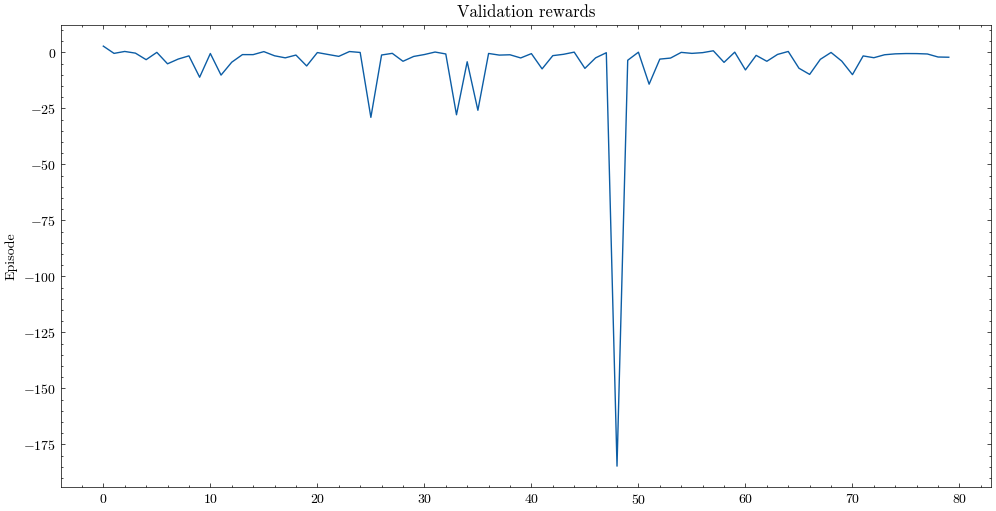

In [15]:
fig = plt.figure(figsize=(12, 6))

plt.plot(training_rewards)
plt.title('Validation rewards')
plt.ylabel('Reward')
plt.ylabel('Episode')
plt.show()

### Save the model

In [16]:
if SAVE:
    drive.mount('/content/drive')
    SAVE_MODEL_DIR = "/content/drive/MyDrive/Uni DK/Master's Thesis/Nets/"
    model.save(SAVE_MODEL_DIR + "tde-bs-high")

Mounted at /content/drive


## Evaluation

In [17]:
test_env = BlackScholesEnvCont(init_s0, init_K, init_T, r, mu, init_vol, init_n_steps)
obs, info = test_env.reset(seed=SEED)

pp = pprint.PrettyPrinter(indent=4)
log_infos = False

rewards = []
hedges = []
bs_deltas = []
hedge_port = []
call_price = []

for i in range(252):
    action, _states = model.predict(obs)

    obs, reward, done, _, info = test_env.step(action)

    rewards.append(reward)
    hedges.append(action)
    bs_deltas.append(info['bs_delta'])
    hedge_port.append(info['hedge_portfolio_value'])
    call_price.append(info['price'])

    if log_infos:
        print(f'Step: {i}')
        print('Action:', action)
        print('Observations:')
        pp.pprint(obs)
        print('Infos')
        pp.pprint(info)
        print('Reward:', reward)

    if done:
        break

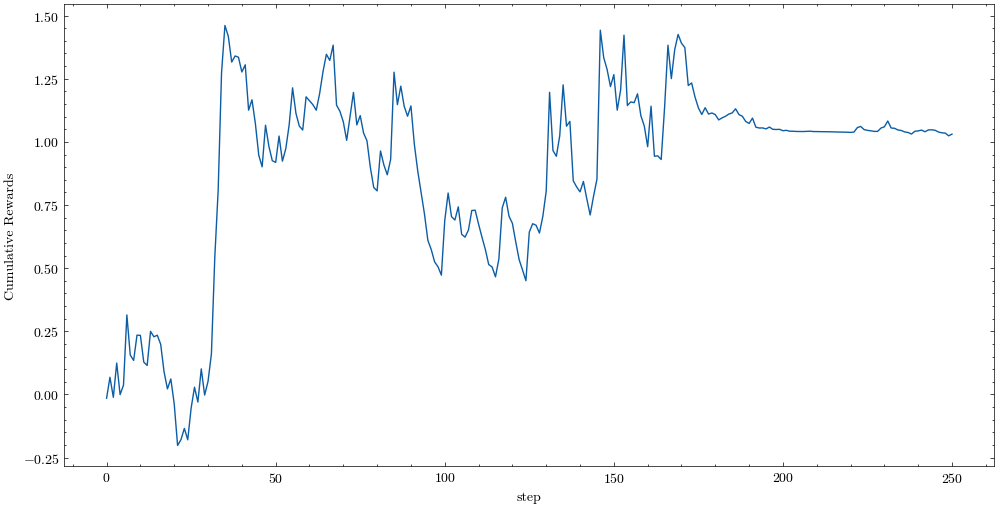

In [18]:
fig = plt.figure(figsize=(12, 6))

plt.plot(np.cumsum(rewards))
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

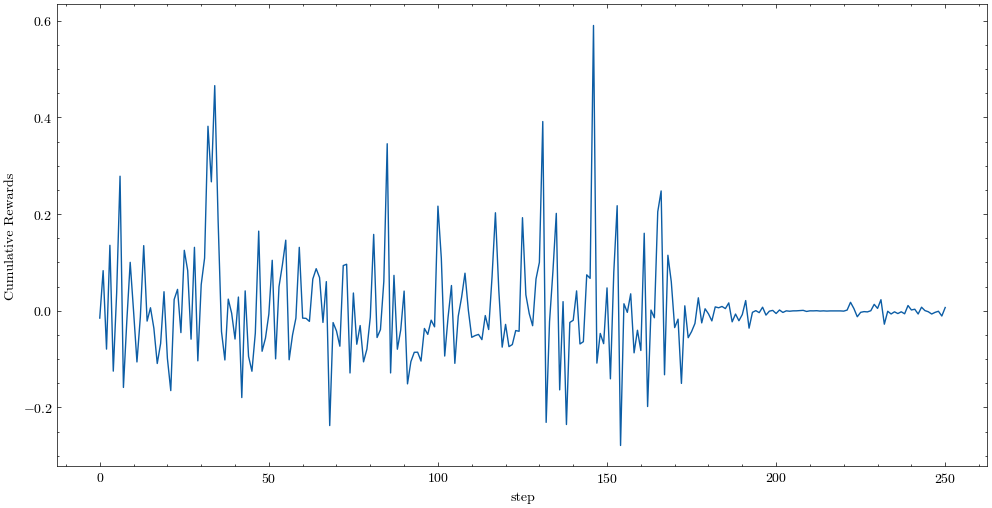

In [19]:
fig = plt.figure(figsize=(12, 6))

plt.plot(rewards)
plt.xlabel('step')
plt.ylabel('Cumulative Rewards')
plt.show()

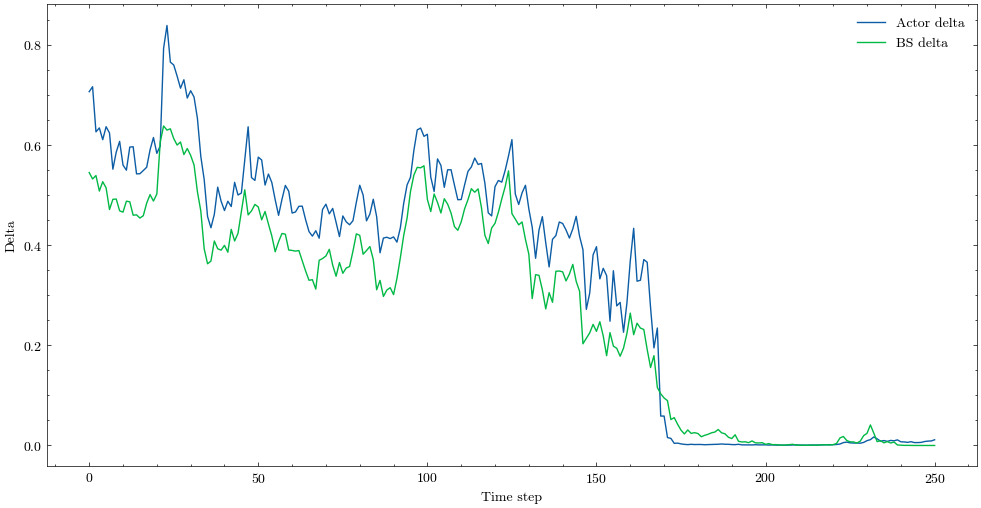

In [20]:
fig = plt.figure(figsize=(12, 6))

plt.plot(-np.array(hedges), label='Actor delta')
plt.plot(bs_deltas, label='BS delta')
plt.xlabel('Time step')
plt.ylabel('Delta')
plt.legend()
plt.show()

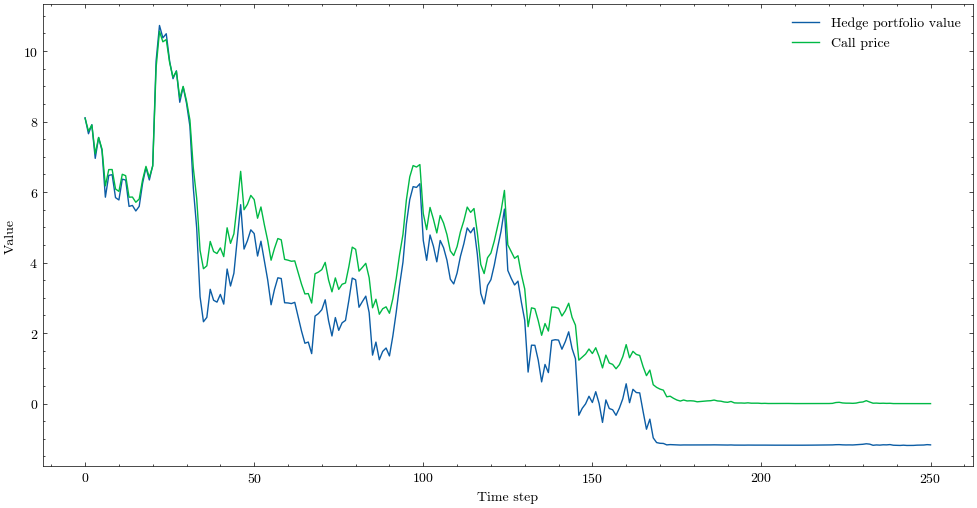

In [21]:
fig = plt.figure(figsize=(12, 6))

plt.plot(hedge_port, label='Hedge portfolio value')
plt.plot(call_price, label='Call price')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show()